# BERT

In [2]:
import pandas as pd
from pathlib import Path

from geopy.geocoders import Nominatim
import numpy as np
from fasttext import load_model
import torch
import transformers

from transformers import BertTokenizer
from tqdm import tqdm
tqdm.pandas()

In [3]:
DATA_DIR = Path("/home/knikaido/work/atma10/data/")

In [4]:
train = pd.read_csv(DATA_DIR / 'train.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')
whole_df = pd.concat([train, test]).reset_index(drop=True)

In [4]:
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-multilingual-cased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [5]:
BSV = BertSequenceVectorizer() # インスタンス化します

whole_df['description'] = whole_df['description'].fillna("NaN") # null は代わりのもので埋めます
whole_df['description_feature'] = whole_df['description'].progress_apply(lambda x: BSV.vectorize(x))
whole_df[['object_id', 'description', 'description_feature']].head()

100%|██████████| 24034/24034 [04:05<00:00, 97.90it/s]


,object_id,description,description_feature
0,0011d6be41612ec9eae3,NaN,"[0.4363969, -0.33500546, 0.66792256, 0.3188178..."
1,0012765f7a97ccc3e9e9,NaN,"[0.4363969, -0.33500546, 0.66792256, 0.3188178..."
2,0017be8caa87206532cb,"Portret van eenvrouw, zittend naast een tafel.","[0.08102478, -0.029493684, 0.11164457, 0.05564..."
3,00181d86ff1a7b95864e,"Een sint-bernardshond, staand in een landschap...","[0.16232015, 0.2928475, -0.13782187, 0.2148054..."
4,001c52ae28ec106d9cd5,Woelige zee met zeilschepen.,"[-0.16510862, 0.100708954, -0.27605268, 0.2566..."


In [6]:
feats = []
for feat in tqdm(whole_df['description_feature']):
    feats.append(feat)

100%|██████████| 24034/24034 [00:00<00:00, 3202525.73it/s]


In [7]:
feats = np.array(feats)

In [8]:
bert = pd.DataFrame(feats)
bert = bert.add_prefix('bert_description')
bert

,bert_0,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,bert_8,bert_9,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
0,0.436397,-0.335005,0.667923,0.318818,0.031258,-0.095407,-0.153340,-0.259155,0.369517,0.258501,...,-0.165604,-0.289044,-0.589709,-0.281332,0.260206,0.284698,0.160815,0.512557,-0.175027,0.298428
1,0.436397,-0.335005,0.667923,0.318818,0.031258,-0.095407,-0.153340,-0.259155,0.369517,0.258501,...,-0.165604,-0.289044,-0.589709,-0.281332,0.260206,0.284698,0.160815,0.512557,-0.175027,0.298428
2,0.081025,-0.029494,0.111645,0.055647,-0.029010,-0.188774,-0.053420,0.510158,-0.048379,0.167398,...,-0.078343,-0.018804,-0.492969,-0.214955,-0.026198,0.398696,0.208457,0.301124,-0.025617,-0.261244
3,0.162320,0.292848,-0.137822,0.214805,0.051047,-0.007916,-0.101624,0.233093,0.126657,0.100643,...,0.118975,-0.089567,-0.195347,0.047634,0.402791,0.122497,0.208271,0.225830,0.204910,-0.047266
4,-0.165109,0.100709,-0.276053,0.256683,0.097252,-0.041171,-0.102088,0.330880,-0.091177,-0.129871,...,0.268689,0.139624,-0.278159,-0.141076,0.427870,0.464427,0.095715,0.104750,-0.055913,-0.321795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24029,0.436397,-0.335005,0.667923,0.318818,0.031258,-0.095407,-0.153340,-0.259155,0.369517,0.258501,...,-0.165604,-0.289044,-0.589709,-0.281332,0.260206,0.284698,0.160815,0.512557,-0.175027,0.298428
24030,0.179572,0.016637,0.148611,0.246306,0.050472,0.167504,-0.159310,0.196196,-0.077328,0.063593,...,0.229990,0.014408,-0.260007,-0.319624,0.173685,0.254705,0.575190,0.393919,-0.078642,-0.080274
24031,0.436397,-0.335005,0.667923,0.318818,0.031258,-0.095407,-0.153340,-0.259155,0.369517,0.258501,...,-0.165604,-0.289044,-0.589709,-0.281332,0.260206,0.284698,0.160815,0.512557,-0.175027,0.298428
24032,0.436397,-0.335005,0.667923,0.318818,0.031258,-0.095407,-0.153340,-0.259155,0.369517,0.258501,...,-0.165604,-0.289044,-0.589709,-0.281332,0.260206,0.284698,0.160815,0.512557,-0.175027,0.298428


In [9]:
bert.to_csv(DATA_DIR / 'bert_description_info.csv', index=False)

In [5]:
BSV = BertSequenceVectorizer() # インスタンス化します

whole_df['more_title'] = whole_df['more_title'].fillna("NaN") # null は代わりのもので埋めます
whole_df['more_title_feature'] = whole_df['more_title'].progress_apply(lambda x: BSV.vectorize(x))
whole_df[['object_id', 'more_title', 'more_title_feature']].head()

100%|██████████| 24034/24034 [03:47<00:00, 105.48it/s]


,object_id,more_title,more_title_feature
0,0011d6be41612ec9eae3,The Avenue of Birches,"[0.04931208, 0.7665747, 0.81470406, -0.5276066..."
1,0012765f7a97ccc3e9e9,Struik in bloei,"[0.12720348, 0.043612603, -0.03605654, 0.23101..."
2,0017be8caa87206532cb,Portret van een vrouw,"[0.2025537, 0.14290923, 0.6457228, 0.16781564,..."
3,00181d86ff1a7b95864e,A St Bernard Dog,"[0.32256234, 0.2494611, 0.7333057, 0.40824428,..."
4,001c52ae28ec106d9cd5,Woelige zee met zeilschepen,"[-0.16938911, 0.09932725, -0.123310484, 0.3174..."


In [6]:
feats = []
for feat in tqdm(whole_df['more_title_feature']):
    feats.append(feat)

100%|██████████| 24034/24034 [00:00<00:00, 2735351.32it/s]


In [7]:
feats = np.array(feats)

In [8]:
bert = pd.DataFrame(feats)
bert = bert.add_prefix('bert_m_title')
bert

,bert_m_title0,bert_m_title1,bert_m_title2,bert_m_title3,bert_m_title4,bert_m_title5,bert_m_title6,bert_m_title7,bert_m_title8,bert_m_title9,...,bert_m_title758,bert_m_title759,bert_m_title760,bert_m_title761,bert_m_title762,bert_m_title763,bert_m_title764,bert_m_title765,bert_m_title766,bert_m_title767
0,0.049312,0.766575,0.814704,-0.527607,0.533250,-0.318285,0.083805,-0.312866,0.240335,0.160902,...,-0.087016,0.134078,-0.387611,0.531272,0.132800,0.332719,0.279988,0.494825,0.342932,-0.236215
1,0.127203,0.043613,-0.036057,0.231014,-0.014816,0.115321,-0.263690,0.222706,0.011416,0.189133,...,0.051240,-0.075440,-0.098389,-0.102566,0.170733,0.172204,0.216893,0.112512,0.127421,-0.257976
2,0.202554,0.142909,0.645723,0.167816,-0.452268,0.049697,0.097406,0.530007,-0.175783,0.158972,...,-0.064766,-0.082976,-0.412183,-0.242250,0.265775,0.743733,0.066910,0.782597,-0.002905,-0.363631
3,0.322562,0.249461,0.733306,0.408244,0.178827,-0.290640,0.028453,-0.026378,0.238561,-0.042622,...,0.084100,-0.182657,-0.569690,0.014396,0.282537,0.482924,0.172056,0.387789,-0.011398,-0.104397
4,-0.169389,0.099327,-0.123310,0.317425,0.182725,0.148183,0.027055,0.148792,0.039495,0.011896,...,0.164947,-0.069277,-0.351311,-0.015143,0.348273,0.420578,0.084225,0.134806,0.028998,-0.228390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24029,-0.020555,0.267843,0.522623,-0.120870,-0.214428,-0.304110,0.046106,0.164648,0.013880,0.103851,...,-0.086087,-0.150910,0.017249,-0.099461,0.085763,0.446498,-0.088174,0.430310,0.021097,-0.420005
24030,-0.115095,0.208502,0.053773,0.064734,0.068849,0.207331,0.095262,0.178955,-0.145865,0.121515,...,-0.064823,-0.226709,-0.352493,0.033296,0.186120,0.290493,-0.000680,0.493672,0.022679,-0.185475
24031,0.078704,0.027466,0.305227,-0.110398,0.049650,-0.210906,-0.211658,0.096260,0.389563,0.220523,...,0.178678,0.106534,0.004479,-0.651970,0.545790,0.245570,0.373494,0.047775,-0.042984,-0.155043
24032,-0.034488,0.055303,0.091819,0.042494,0.137728,-0.035609,0.089097,0.345863,-0.048964,-0.155563,...,0.054538,-0.172811,-0.033546,-0.068851,0.246846,0.496930,0.104295,0.323776,0.127751,-0.258454


In [9]:
bert.to_csv(DATA_DIR / 'bert_more_title_info.csv', index=False)

In [5]:
BSV = BertSequenceVectorizer() # インスタンス化します

whole_df['long_title'] = whole_df['long_title'].fillna("NaN") # null は代わりのもので埋めます
whole_df['long_title_feature'] = whole_df['long_title'].progress_apply(lambda x: BSV.vectorize(x))
whole_df[['object_id', 'long_title', 'long_title_feature']].head()

100%|██████████| 24034/24034 [04:00<00:00, 99.81it/s] 


,object_id,long_title,long_title_feature
0,0011d6be41612ec9eae3,"The Avenue of Birches, Jan Hackaert, 1660 - 1685","[-0.09067142, 0.1197328, 0.20986234, -0.252599..."
1,0012765f7a97ccc3e9e9,"Struik in bloei, Richard Tepe (attributed to),...","[-0.110582195, 0.039560504, 0.028685007, 0.016..."
2,0017be8caa87206532cb,"Portret van een vrouw, Tresling & Comp., 1860 ...","[-0.06363991, 0.057298407, -0.05677837, 0.2650..."
3,00181d86ff1a7b95864e,"A St Bernard Dog, Bernard te Gempt, c. 1850 - ...","[0.03717693, 0.04957635, 0.32675278, 0.0472006..."
4,001c52ae28ec106d9cd5,"Woelige zee met zeilschepen, anonymous, 1825 -...","[-0.17847171, 0.06936048, -0.21129592, 0.05642..."


In [7]:
feats = []
for feat in tqdm(whole_df['long_title_feature']):
    feats.append(feat)
feats = np.array(feats)

100%|██████████| 24034/24034 [00:00<00:00, 2998569.29it/s]


In [8]:
bert = pd.DataFrame(feats)
bert = bert.add_prefix('bert_l_title')
bert

,bert_l_title0,bert_l_title1,bert_l_title2,bert_l_title3,bert_l_title4,bert_l_title5,bert_l_title6,bert_l_title7,bert_l_title8,bert_l_title9,...,bert_l_title758,bert_l_title759,bert_l_title760,bert_l_title761,bert_l_title762,bert_l_title763,bert_l_title764,bert_l_title765,bert_l_title766,bert_l_title767
0,-0.090671,0.119733,0.209862,-0.252600,-0.137693,-0.041237,0.105727,-0.059568,0.125064,0.197294,...,-0.017920,-0.166065,-0.153879,-0.582117,0.267844,0.233068,0.166606,0.363796,0.034911,0.096905
1,-0.110582,0.039561,0.028685,0.016719,0.042893,0.069910,-0.184433,0.019954,-0.044861,-0.077935,...,0.098646,-0.335263,-0.026001,-0.316249,0.148965,0.287926,0.354746,0.205444,0.086432,-0.196759
2,-0.063640,0.057298,-0.056778,0.265095,-0.025779,0.249342,0.410278,0.071422,0.001695,0.199074,...,-0.129876,-0.239028,0.000603,-0.205573,0.187297,0.263782,0.255655,0.442442,0.118391,0.048231
3,0.037177,0.049576,0.326753,0.047201,0.181134,0.036586,0.080689,-0.174580,0.136119,-0.117974,...,-0.130663,-0.259558,0.003074,-0.122279,0.136084,0.176164,0.360074,0.269300,0.139081,-0.168541
4,-0.178472,0.069360,-0.211296,0.056424,0.126693,-0.035513,0.177654,-0.019925,0.196445,-0.149255,...,0.134015,-0.135985,-0.256519,-0.292008,0.301852,0.465109,0.058073,0.343098,0.137674,-0.174473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24029,0.016179,0.073706,0.001086,0.211514,0.102109,0.149128,0.192708,-0.033648,-0.026221,0.124824,...,-0.113105,-0.113161,0.172637,-0.252063,0.254569,0.302111,0.141763,0.296553,0.249819,-0.120106
24030,-0.039179,0.053611,0.103807,0.040824,0.144254,0.173340,0.050673,0.040928,-0.101739,0.120784,...,-0.074173,-0.401912,-0.141715,0.023105,0.041299,0.179370,0.173999,0.343118,-0.023597,-0.159212
24031,-0.199579,0.026951,0.227422,-0.075392,0.003246,0.191641,0.226610,-0.169428,0.269425,0.147123,...,-0.075274,-0.202172,0.162035,-0.418838,0.387824,0.217616,0.235004,0.263643,0.052773,0.014355
24032,0.005990,0.013737,-0.153400,0.327576,0.041012,0.157451,0.230245,-0.064421,0.033394,0.106379,...,-0.116114,-0.133104,0.274696,-0.286618,0.356807,0.381897,0.247489,0.380541,0.143973,-0.073293


In [9]:
bert.to_csv(DATA_DIR / 'bert_long_title_info.csv', index=False)

## TIFDF

In [6]:
train['title']

0                                    The Avenue of Birches
1                                          Struik in bloei
2                                    Portret van een vrouw
3                                         A St Bernard Dog
4                              Woelige zee met zeilschepen
                               ...                        
12021                De schilder H.W. Mesdag voor een doek
12022    Kaart van de streek tussen Mannheim en Landau,...
12023    Storm op het IJ aan het Blauwhoofd van Amsterd...
12024                        Het rad van fortuin, ca. 1689
12025                       The Adoration of the Shepherds
Name: title, Length: 12026, dtype: object

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

docs = train['title'].values

In [31]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100000)),
    ('svd', TruncatedSVD(n_components=50)),
])

z = pipeline.fit_transform(docs)


In [ ]:
z 

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
reduced = pca.fit_transform(z)

In [28]:
z_df = pd.DataFrame(reduced, columns=['dim0', 'dim1'])
z_df['likes'] = np.log1p(train['likes'])

<AxesSubplot:xlabel='dim0', ylabel='dim1'>

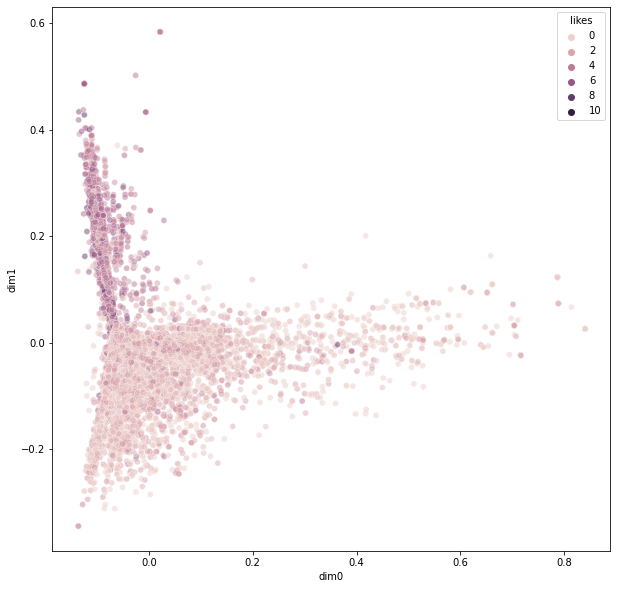

In [29]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="dim0", y="dim1", hue="likes", data=z_df, alpha=0.5)